<a href="https://colab.research.google.com/github/clopensesame/Nazzaro_DSPN_S24/blob/main/Exercise_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 11: The beauty of kNN

In this exercise, you'll gain practice working with kNN. We'll use the [diamonds](https://ggplot2.tidyverse.org/reference/diamonds.html) dataset, which comes as part of `ggplot2`. This dataset provides information on the quality and price of 50,000 diamonds


## 1. Data, Plotting, and Train/Test Sets (2 pts)
-----
* Load the the `class` and `tidyverse` packages.
* Assign the `diamonds` data set to a simpler name. Then, create a new variable `price_bin` that splits the `price` variable into a binary variable, where 1 indicates that the diamond costs greater than the mean price, and 0 indicates that the diamond costs less than the mean price. Set `price_bin` to be a factor. (*Hint: use the if_else() function*)
* Select just the `carat`, `depth`, `table`, `x`, `y`, and your new `price_bin` variables
* Print the first few lines of the data set
* Print the dimensions of the data set


In [1]:
install.packages(c("class","tidyverse"))
library(class)
library(tidyverse)
library(ggplot2)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
dat <- diamonds
meanPrice <- mean(dat$price)

dat <- dat %>%
  mutate(price_bin = if_else(price > mean(price), 1, 0)) %>%
  mutate(price_bin = factor(price_bin))

datselected <- dat %>% select(carat, depth, table, x, y, price_bin)
head(datselected)
dim(datselected)

carat,depth,table,x,y,price_bin
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.23,61.5,55,3.95,3.98,0
0.21,59.8,61,3.89,3.84,0
0.23,56.9,65,4.05,4.07,0
0.29,62.4,58,4.20,4.23,0
0.31,63.3,58,4.34,4.35,0
0.24,62.8,57,3.94,3.96,0


[1] 53940     6

### Plot
Create a scatterplot of the link between `carat` and `depth`, and use the `color` aesthetics mapping to differentiate between diamonds that cost above versus below the mean price.

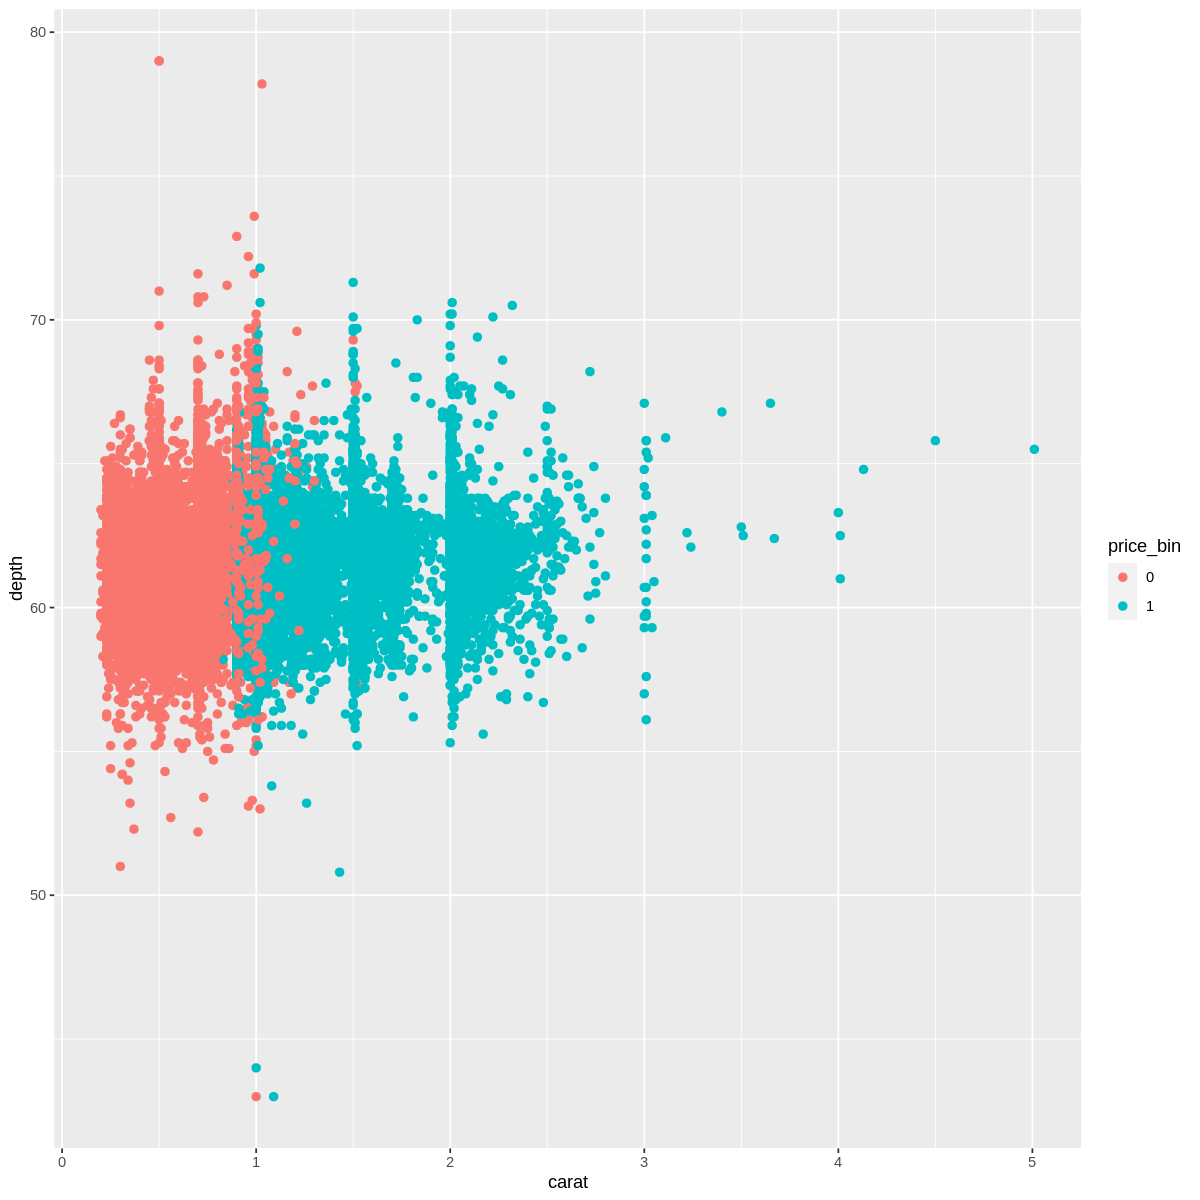

In [3]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(dat,aes(x=carat,y=depth,col=price_bin)) +
geom_point(size=2)

Based on the above scatterplot, how do you think kNN will perform using only these two variables to predict diabetes diagnosis? Which variable, carat or depth, gives us the most information about which price class the diamond will belong to?
> * I think kNN will perform fairly well to predict price_bin, and will find the 2 main groups (lower carat corresponding to price_bin=0 and higher carat corresponding to price_bin=1). However, I think kNN will struggle to define clear boundaries around carat=1 where there is a lot of overlap in price_bin. There are also some outliers in carat=[1,1.5] that kNN will likely struggle with.
> * We see a general pattern of price_bin=1 when carat > 1 and price_bin=0 when carat < 1. We cannot draw a clear pattern in depth, so carat gives more information about which price class the diamond will belong to.
>
>


### Test vs Train

Before we run KNN on these data, we need to set aside a portion of the observations as our test set. Below, randomly divide the data such that 30% are allotted to the `test` set and the rest are allotted to the `train` set. Print the first few lines of each set, and print the dimensions of each set to double check your division of the data.

In [4]:
set.seed(2023)

#pull random sample of 30% of data
test.inds <- sample(1:nrow(dat),0.3*nrow(dat))

# TRUE/FALSE indicator for whether each observation is a test item or not.
dat$is.test <- 1:nrow(dat) %in% test.inds

test <- filter(dat,dat$is.test)
train <- filter(dat,!dat$is.test)

head(test)
head(train)
dim(test)
dim(train)

carat,cut,color,clarity,depth,table,price,x,y,z,price_bin,is.test
<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31,0,TRUE
0.30,Good,J,SI1,64.0,55,339,4.25,4.28,2.73,0,TRUE
0.30,Ideal,I,SI2,62.0,54,348,4.31,4.34,2.68,0,TRUE
0.30,Good,J,SI1,63.4,54,351,4.23,4.29,2.70,0,TRUE
0.30,Very Good,J,SI1,62.7,59,351,4.21,4.27,2.66,0,TRUE
0.23,Very Good,E,VS2,63.8,55,352,3.85,3.92,2.48,0,TRUE


carat,cut,color,clarity,depth,table,price,x,y,z,price_bin,is.test
<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43,0,FALSE
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31,0,FALSE
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63,0,FALSE
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75,0,FALSE
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48,0,FALSE
0.24,Very Good,I,VVS1,62.3,57,336,3.95,3.98,2.47,0,FALSE


[1] 16182    12

[1] 37758    12

## 2: KNN (3 points)
----
Now, use the `knn()` function from the `class` library to predict `price_bin` from the `carat` and `depth`. Set `k = 3`.

*Hint: Review the format required for the arguments of knn()*

In [5]:
#training data pulls the "not test" rows
train.preds <- cbind(dat$carat[-test.inds], dat$depth[-test.inds])
train.spec <- dat$price_bin[-test.inds]
#testing data pulls the test rows
test.preds <- cbind(dat$carat[test.inds], dat$depth[test.inds])

#run knn
test.spec.knn <- knn(train.preds, test.preds, train.spec, k = 3)

#print first 10 test specifications
test.spec.knn[1:10]

[1] 1 1 1 0 0 1 1 0 0 0
Levels: 0 1

Now, output a confusion matrix and calculate the test error to evaluate model performance.

In [6]:
confusion_df <- data.frame(predicted = test.spec.knn,actual = dat$price_bin[test.inds])
table(confusion_df)
print("---")
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

         actual
predicted    0    1
        0 9699  326
        1  547 5610

[1] "---"
[1] "Accuracy: 0.946051167964405"


How did your model perform?
> * Our model has an accuracy of 94.61%


Let's try to improve our model by adding all of the other variables in our data set as predictors. Rerun your `knn()` below, keeping `k = 3`. Again, output a confusion matrix and error rate for your updated model fit.

In [7]:
#training data pulls the "not test" rows
train.preds <- cbind(dat$carat[-test.inds], dat$clarity[-test.inds],
dat$color[-test.inds], dat$cut[-test.inds], dat$depth[-test.inds], dat$is.test[-test.inds],
dat$table[-test.inds],
dat$x[-test.inds], dat$y[-test.inds], dat$z[-test.inds])
#price_bin
train.spec <- dat$price_bin[-test.inds]
#testing data pulls the test rows
test.preds <- cbind(dat$carat[test.inds], dat$clarity[test.inds],
dat$color[test.inds], dat$cut[test.inds], dat$depth[test.inds], dat$is.test[test.inds],
dat$table[test.inds],
dat$x[test.inds], dat$y[test.inds], dat$z[test.inds])
#run knn
test.spec.knn <- knn(train.preds, test.preds, train.spec, k = 3)

confusion_df <- data.frame(predicted = test.spec.knn,actual = dat$price_bin[test.inds])
table(confusion_df)
print("---")
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

         actual
predicted    0    1
        0 9836  348
        1  410 5588

[1] "---"
[1] "Accuracy: 0.953157829687307"


Did your model predictions improve?
> * Yes, the accuracy went up slightly from 94.61% to 95.32%.


# 3: for loop (3 points)
----

So adding additional predictors didn't shift our error much. Let's see if adjusting `k` has a larger impact on model accuracy.

Using your initial model above with just `carat` and `depth`, run a `for loop` that runs the same model 30 times, for `k = 1:30`.

Output a data frame that has `k` and the overall `error` as columns.

The structure of the output data frame and `for loop` are provided for you below. Note that your loop will take a minute or two to run because there are so many observations in the dataset. It may be helpful while you are writing and testing your loop to run it on a subset of the data with only a handful of rows.

In [8]:
# this is provided
# setting up empty table to store for loop output
output  <- data.frame(k = seq(1:30),
                     error = rep(NA, 30))

head(output)

#training data pulls the "not test" rows
train.preds <- cbind(dat$carat[-test.inds], dat$depth[-test.inds])
train.spec <- dat$price_bin[-test.inds]
#testing data pulls the test rows
test.preds <- cbind(dat$carat[test.inds], dat$depth[test.inds])

,k,error
,<int>,<lgl>
1,1,NA
2,2,NA
3,3,NA
4,4,NA
5,5,NA
6,6,NA


In [9]:
for (k in seq(1:30)) {
    knn_fits  <- knn(train.preds, test.preds, train.spec, k)

    #overall error
    conf_df  <- data.frame(predicted = knn_fits,actual = dat$price_bin[test.inds])
    output$error[k]  <- mean(conf_df$predicted == conf_df$actual)
    output$k[k] <- k

}
head(output)

,k,error
,<int>,<dbl>
1,1,0.9462984
2,2,0.9465455
3,3,0.9466691
4,4,0.9463602
5,5,0.9473489
6,6,0.9474725


In [10]:
output

k,error
<int>,<dbl>
1,0.9462984
2,0.9465455
3,0.9466691
4,0.9463602
5,0.9473489
6,0.9474725
7,0.9477197
8,0.9485848
9,0.9483995


Create a line plot of your `output` object using `ggplot`. Add a (non-linear) `geom_smooth` layer.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


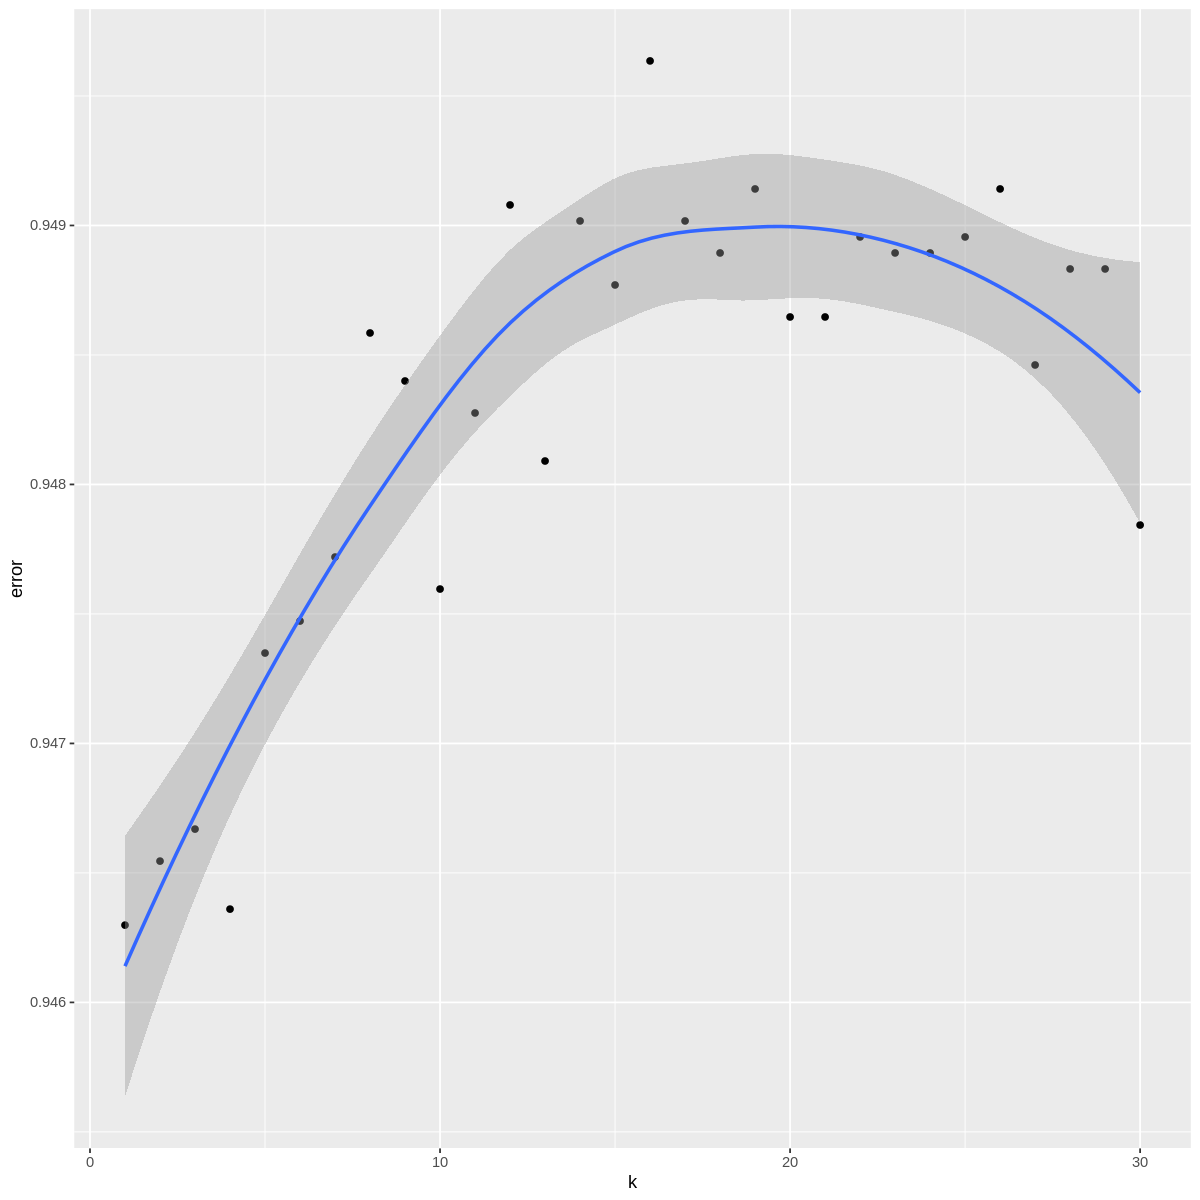

In [11]:
ggplot(output, aes(x = k, y = error)) +
        geom_point(size = 1.5) +
        geom_smooth() #add reference line

Interpret your plot. What would you select as the best value of `k`? How much does this improve your test error?
> * According to the blue line on the plot, the accuracy (error) peaks around k=20. This value of k only improves our test error marginally, as we are only improving accuracy on the order of 0.001, or 0.1%.


# 4: Standardizing predictors (2)
-----

Because knn is based on distances between points, it is very sensitive to the scale of your variables. Looking at our predictor variables, we can see that `carat` and `depth` are orders of magnitude different in terms of scales. Maybe we can improve our fit even more by addressing this!

Below, use the `scale()` function to standardize your predictors. (Note that you don't need to standardize `price_bin`.)

Then, run your model a final time with your standardized predictors (just `carat` and `depth` still). Set `k` to the optimal value you determined in your plot above. Output the confusion matrix and error rate again.

In [13]:
set.seed(2023)

#training data pulls the "not test" rows
train.preds <- cbind(dat$carat[-test.inds], dat$depth[-test.inds])
train.spec <- dat$price_bin[-test.inds]
#testing data pulls the test rows
test.preds <- cbind(dat$carat[test.inds], dat$depth[test.inds])

stand.train.preds <- scale(train.preds)
stand.test.preds <- scale(test.preds)

#run knn
test.spec.knn <- knn(stand.train.preds, stand.test.preds, train.spec, k = 20)

#print first 10 test specifications
test.spec.knn[1:10]

confusion_df <- data.frame(predicted = test.spec.knn,actual = dat$price_bin[test.inds])
table(confusion_df)
print("---")
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

[1] 1 1 1 0 0 1 1 0 0 0
Levels: 0 1

         actual
predicted    0    1
        0 9719  294
        1  527 5642

[1] "---"
[1] "Accuracy: 0.949264615004326"


What impact did rescaling the data have on your error rate?
> * The rescaled accuracy is 0.9493, a slight increase from the original at k=20, where accuracy was 0.9486.


**DUE:** 5pm March 20, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*
>
>
